In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
import random
import corner
# Show plots inline, and load main getdist plot module and samples class
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
# use this *after* importing getdist if you want to use interactive plots
# %matplotlib notebook
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True


GetDist Version: 1.1.2, Matplotlib version: 3.3.1


In [2]:
#introducción de los datos
#N es la cantidad de datos, NN el número de iteraciones para el programa caminante
#definición de av y bv para guardar los parámetros que cumplen la regla de selección
#av[0] y bv[0] son los parametros iniciales dados por uno, cv, y la creación de otras listas es para 
#parametros de otros modelos
#x1 y y1 son los datos 
N=50
NN=10000
dt=np.load('fit_exercise.npy')
x1 = dt[0]
y1 = dt[1]
v=0.1
av=np.zeros(NN)
bv=np.zeros(NN)

Usare un prior plano i.e cuando tenemos un prior plano:
$$e^{-\frac{(\mu-\mu_{0})^{2}}{2\sigma_{0}^{2}}}\rightarrow 1$$
cuando $\mu_{0}=0$ y $\sigma_{0}\rightarrow \infty$ así en el posterior solo queda el likelihood por maximizar
$$e^{-\frac{(y_{i}-\mu)^{2}}{2\sigma^{2}}}$$, recordando $\mu$ es el modelo

In [3]:
def modelo(a, b):
        mod = a + (b*x1)
    #mod=a*(x**2)+b*x + c
    #mod=a*np.cos(b*x)+c
        return mod

In [4]:
#menos logaritmo de likelihood gaussiano
def ls(a, b):
        mu = modelo(a, b)
        #-(n*0.5)*np.log(2*np.pi*var)
        f = 0.5*(v**(-1))*np.sum((y1-mu)**2)
        return f

In [5]:
def MCM3(p1, p2):
#v, varianza de nuestros datos
#vector a guardar parametros, av, bv, cv, dependiendo del modelo
#hay que modificar los parametros que pide modelo, likelihood y MCM2
#likelihood, puede ser distinto al gaussiano
#x1, y1 los datos
#n cantidad de datos
#NN iteraciones
    #v = np.var(y1)
    av[0] = p1
    bv[0] = p2
    accepteda = []
    acceptedb = []
    rejecteda = [] 
    rejectedb = []   
    for k in range(NN-1):
        ak = np.random.normal(av[k], 0.1)
        bk = np.random.normal(bv[k], 0.1)
        posteriorold = ls(av[k], bv[k])
        posteriornew = ls(ak, bk)
        if posteriornew < posteriorold:
            av[k+1] = ak
            bv[k+1] = bk
            accepteda.append(ak)
            acceptedb.append(bk)
        else:
            ran = -np.log(random.uniform(0, 1))
            ratio = posteriornew-posteriorold
            if ratio < ran:
                av[k+1] = ak
                bv[k+1] = bk
                accepteda.append(ak)
                acceptedb.append(bk)
            else:
                av[k+1] = np.copy(av[k])
                bv[k+1] = np.copy(bv[k])
                rejecteda.append(ak)
                rejectedb.append(bk)  
    ta=np.array(accepteda)
    tb=np.array(acceptedb)
    ra=np.array(rejecteda)
    rb=np.array(rejectedb)
    porc_a=(len(ta)/NN)*100
    porc_b=(len(ta)/NN)*100
    return av, bv, porc_a, porc_b
#, ra, rb, plt.plot(ta, tb, 'o'), print('el parámetro a es', ta.mean()), print('el parámetro b es', tb.mean())

In [6]:
MCM3(1,2)

(array([1.        , 1.1517597 , 1.16776563, ..., 4.63814623, 4.63814623,
        4.63814623]),
 array([ 2.        ,  1.89808189,  1.8331694 , ..., -0.99768344,
        -0.99768344, -0.99768344]),
 8.59,
 8.59)

## Multiples caminadores

In [7]:
def multMCM(l, g):
    s1 = np.zeros((5, NN))
    s2 = np.zeros((5, NN))
    porca = np.zeros(5)
    porcb = np.zeros(5)
    for k in range(5):
        s1[k], s2[k], porca[k], porcb[k]=np.copy(MCM3(l[k], g[k]))
    return s1, s2, porca, porcb

In [8]:
l=np.array([1, 3, 2, 1, 2])
g=np.array([4, 3, 4, 3, 2])

In [9]:
s1, s2, pa, pb=multMCM(l, g)

C:\Users\ana__\miniconda3\envs\hola\lib\site-packages\numpy\lib\function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


## Análisis cuantitativo de cadenas

el porcentaje de aceptación para el parametro a y b respectivamente es:

In [10]:
pa.mean()

9.024000000000001

In [11]:
pb.mean()

9.024000000000001

La media y varianza de los 5 caminantes para el parametro a es 

In [12]:
s1.mean()

4.516608045564599

In [13]:
s1.var()

0.1835777360319896

La media y varianza de los 5 caminantes para el parametro b es 

In [14]:
s2.mean()

-0.9524743067336183

In [15]:
s2.var()

0.07697437574605229

In [126]:
#para el diagnóstico de Gelman-Rubin 
muv=np.zeros(2)
muv[0]=s1.mean()
muv[1]=s2.mean()

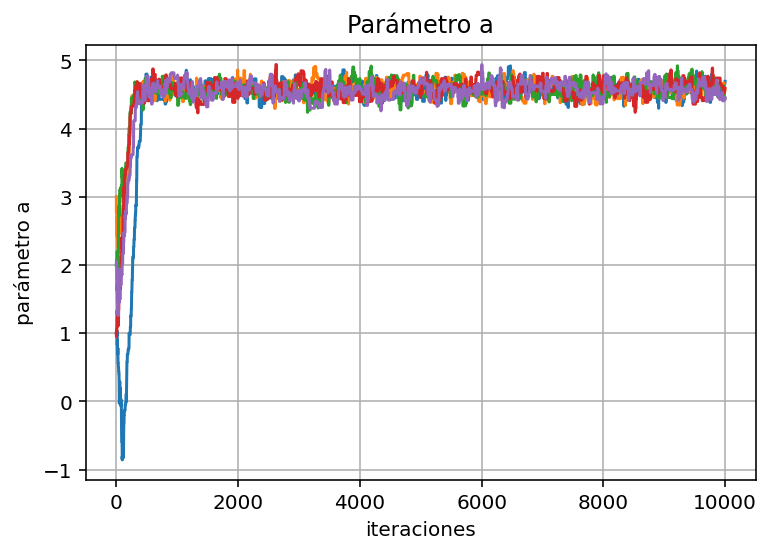

In [165]:
for i in range(5):
    plt.plot(np.arange(NN), s1[i])
plt.title(label='Parámetro a')
plt.xlabel('iteraciones')
plt.ylabel('parámetro a')
plt.grid()

Text(0, 0.5, 'parámetro b')

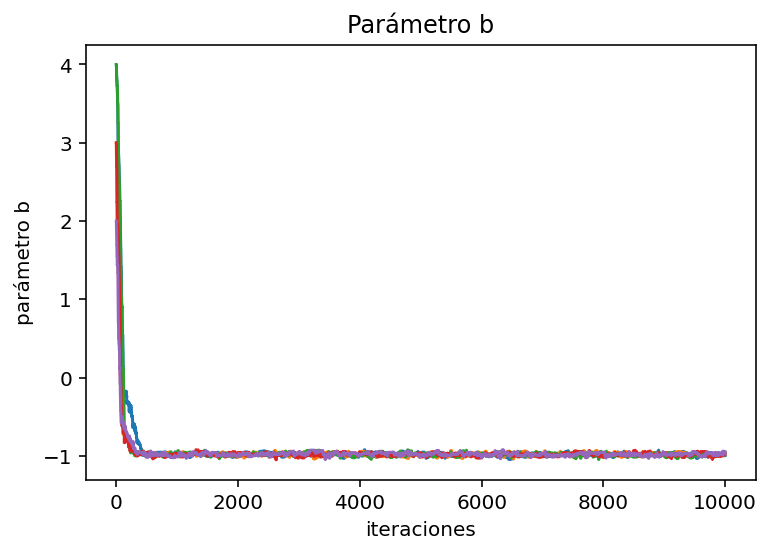

In [28]:
for i in range(5):
    plt.plot(np.arange(NN), s2[i])
plt.title(label='Parámetro b')
plt.xlabel('iteraciones')
plt.ylabel('parámetro b')

## Gráficas triangulares

### Definición de samples

In [20]:
samps=np.array([s1[0].T, s2[0].T]).T

In [164]:
samps[1][0]

1.0

In [21]:
samps2=np.array([s1[1].T, s2[1].T]).T

In [22]:
samps3=np.array([s1[2].T, s2[2].T]).T

In [23]:
samps4=np.array([s1[3].T, s2[3].T]).T

In [24]:
samps5=np.array([s1[4].T, s2[4].T]).T

In [150]:
ndim = 2
nsamp = NN

In [151]:
names = ['a0', 'b0']
labels =  ['a', 'b']
samples = MCSamples(samples=samps,names = names, labels = labels, label='first set')
samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')
samples3 = MCSamples(samples=samps3,names = names, labels = labels, label='Second set')
samples4 = MCSamples(samples=samps4,names = names, labels = labels, label='Second set')
samples5 = MCSamples(samples=samps5,names = names, labels = labels, label='Second set')


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


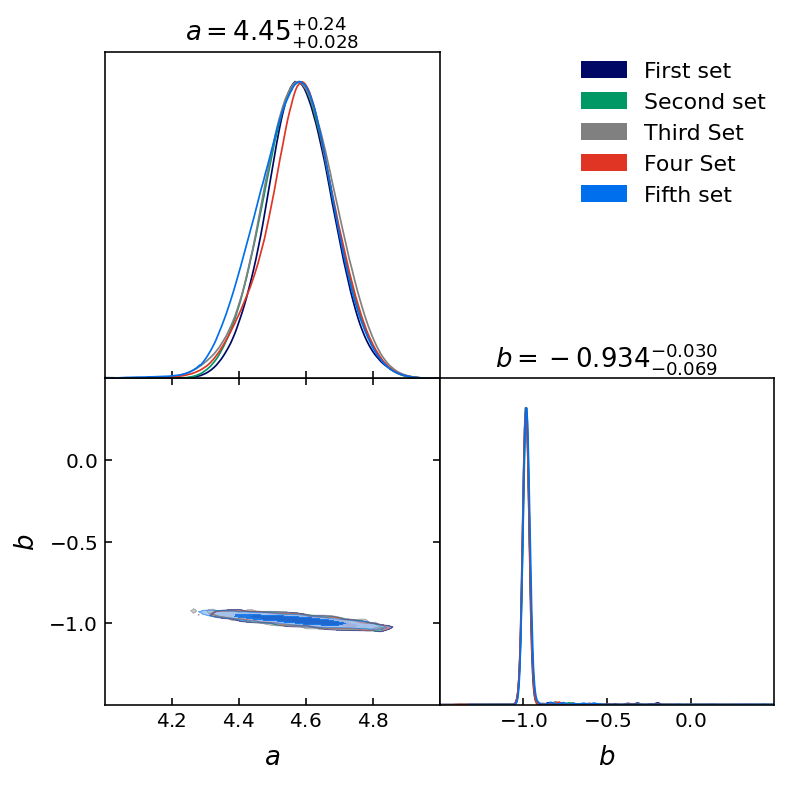

In [160]:
#### Triangle plot 
g = plots.get_subplot_plotter(width_inch=6)
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=1, param_limits={'a0': (4, 5), 'b0': (-1.5, 0.5)})
#  title limit same to 1 (for 1D plots) is 68% by default

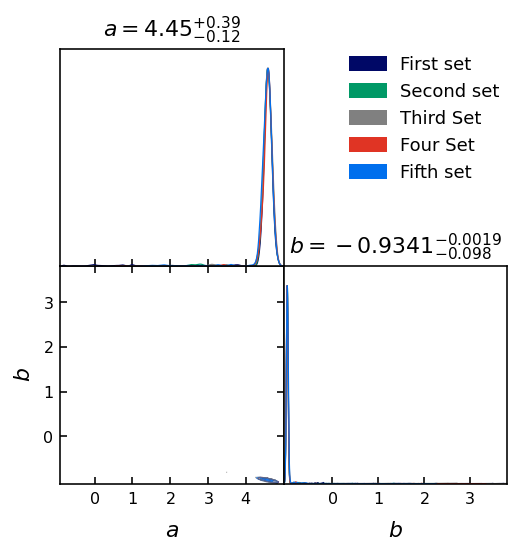

In [32]:
# Triangle plot 
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=2)
#  title limit 2

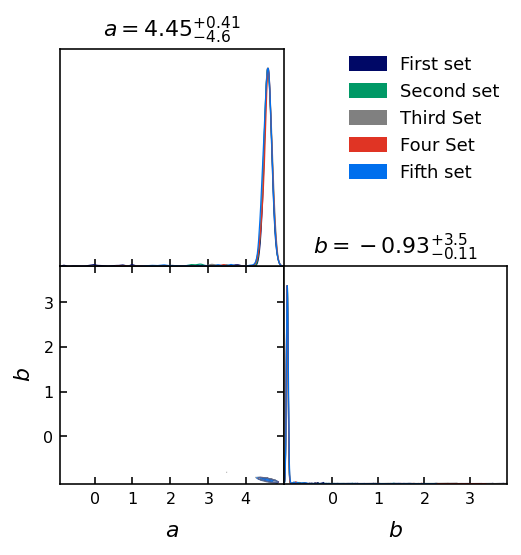

In [149]:
# Triangle plot 
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=3)
#  title limit 3

## Diagnóstico de Gelman-Rubin

$\hat{\mu} $ promedio de la muestra de los mn valores simulados de x, $\hat{\mu} $=$\bar{x}$

In [99]:
#uní los arreglos para los calculos
s=np.array([s1, s2])

In [113]:
sksq=np.zeros([2,5])
for k in range(2):
    for i in range(5):
        gr1=0
        for j in range(N):
            gr=(s[k][i][j]-s[k][i].mean())**2
            gr1=gr1+gr    
        sksq[k][i]=gr1/(N-1)

Calculo del promedio de las m varianzas, $s_{i}^{2}$, cada una dividida entre n-1 grados de libertad en la celda anterior

In [121]:
ssq=np.zeros(2)
for i in range(2):
    ssq[i]=(np.sum(sksq[i]))/5

Cálculo de B/n la varianza entre las m secuencias de media, $\bar{x_{i}}$, cada una en base de los n valores de x

In [135]:
sum=0
Bn=np.zeros(2)
for k in range(2):
    for i in range(5):
        dd=((s[k][i].mean()-muv[k])**2)
        sum=sum+dd
    Bn[k]=sum/4

Varianza $\hat{\sigma^{2}}$

In [136]:
varsq=np.zeros(2)
for k in range(2):
    varsq[k]=(N-1)*ssq[k]*(N**(-1))+Bn[k]

In [137]:
R=np.zeros(2)
for i in range(2):
    R[i]=math.sqrt(varsq[i]/ssq[i])

In [138]:
R

array([0.99004224, 0.99002644])